# Phase 1: Static Line Formation

**Goal**: Train the NCA to redistribute mass from a blob into a stable line formation.

**Key Principle**: Mass is CONSERVED. The seed starts with the same mass as the target. 
The NCA learns to reshape, not grow.

**Approach**:
- Seed: Gaussian blob with mass = target mass
- Target: Line formation
- Loss: Formation shape + Mass conservation

**Success Criteria**:
- Formation loss < 0.01
- Mass conserved within 10% of initial
- Stable formation maintained over 100+ steps

**Next Step**: Once Phase 1 is complete, proceed to `phase2_formation_transitions.ipynb`

In [232]:
# Setup
import subprocess
import sys
import os

REPO_URL = "https://github.com/JackHopkins/FormationHNCA.git"

if os.path.exists("/content"):
    REPO_DIR = "/content/FormationHNCA"
elif os.path.exists("/workspace"):
    REPO_DIR = "/workspace/FormationHNCA"
else:
    REPO_DIR = os.path.expanduser("~/FormationHNCA")

if os.path.exists(REPO_DIR):
    print(f"Pulling latest changes in {REPO_DIR}...")
    result = subprocess.run(["git", "-C", REPO_DIR, "pull"], capture_output=True, text=True)
    print(result.stdout or "Already up to date.")
else:
    print(f"Cloning repository to {REPO_DIR}...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

print("Installing JAX with CUDA support...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "jax[cuda12]"], check=True)

print("Installing battle-nca package...")
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)

src_path = os.path.join(REPO_DIR, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(f"\nWorking directory: {os.getcwd()}")
print("Setup complete!")

Pulling latest changes in /workspace/FormationHNCA...
Already up to date.

Installing JAX with CUDA support...
Installing battle-nca package...

Working directory: /workspace/FormationHNCA
Setup complete!


In [233]:
import jax
import gc

gc.collect()
jax.clear_caches()

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

if jax.devices()[0].platform == 'gpu':
    print("GPU acceleration enabled!")
else:
    print("WARNING: Running on CPU.")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]
GPU acceleration enabled!


In [234]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import time
import pickle
from pathlib import Path

from battle_nca.core import NCA, perceive
from battle_nca.core.nca import create_seed
from battle_nca.hierarchy import ChildNCA, ParentNCA, HierarchicalNCA
from battle_nca.hierarchy.child_nca import create_army_seed, CHILD_CHANNELS
from battle_nca.combat import FormationTargets, create_formation_target, rotate_formation
from battle_nca.combat.formations import FormationTypes
from battle_nca.training import NCAPool, Trainer, TrainingConfig
from battle_nca.training.optimizers import create_optimizer, normalize_gradients

print("All imports successful!")

All imports successful!


## Configuration

In [235]:
GRID_SIZE = 64
NUM_CHANNELS = 24

# RESET: Set to True to retrain from scratch
RESET = True

config = TrainingConfig(
    batch_size=16,
    pool_size=1024,
    min_steps=256,
    max_steps=256,
    learning_rate=2e-3,
    gradient_clip=1.0,
    damage_samples=3,
    damage_start_epoch=500,
    log_interval=10,
    checkpoint_interval=500
)

PHASE1_EPOCHS = 128
SEED = 42

CHECKPOINT_PATH = Path('checkpoints/phase1_line.pkl')
CHECKPOINT_PATH.parent.mkdir(exist_ok=True)

key = jax.random.PRNGKey(SEED)

print(f"Phase 1: Line Formation Training")
print(f"Steps per iteration: {config.min_steps}")
print(f"Max epochs: {PHASE1_EPOCHS}")

Phase 1: Line Formation Training
Steps per iteration: 256
Max epochs: 128


## Create Model and Initialize

In [236]:
child_nca = ChildNCA(
    num_channels=NUM_CHANNELS,
    hidden_dim=128,
    fire_rate=0.5,
    use_circular_padding=True
)

# First, compute target mass so we can create a matching seed
target = FormationTargets.line(GRID_SIZE, GRID_SIZE)
TARGET_MASS = float(jnp.sum(target[..., 3]))

def create_gaussian_seed(height, width, num_channels, target_mass, key, sigma=8.0):
    """Create a Gaussian blob seed with specified total mass.
    
    The blob is centered and normally distributed, with alpha values
    scaled so total mass equals target_mass.
    
    Args:
        height, width: Grid dimensions
        num_channels: Number of channels (24)
        target_mass: Desired total mass (sum of alpha channel)
        key: PRNG key for any randomness
        sigma: Standard deviation of Gaussian
    
    Returns:
        Seed state with Gaussian alpha distribution
    """
    state = jnp.zeros((height, width, num_channels))
    
    # Create Gaussian blob centered in grid
    cy, cx = height // 2, width // 2
    y = jnp.arange(height)
    x = jnp.arange(width)
    yy, xx = jnp.meshgrid(y, x, indexing='ij')
    
    # Gaussian distribution
    dist_sq = (yy - cy) ** 2 + (xx - cx) ** 2
    gaussian = jnp.exp(-dist_sq / (2 * sigma ** 2))
    
    # Scale to match target mass
    current_mass = jnp.sum(gaussian)
    alpha = gaussian * (target_mass / current_mass)
    
    # Clip to valid range [0, 1]
    alpha = jnp.clip(alpha, 0.0, 1.0)
    
    # Set RGBA channels
    state = state.at[..., 0].set(1.0)  # R (team color)
    state = state.at[..., 1].set(0.0)  # G
    state = state.at[..., 2].set(0.0)  # B
    state = state.at[..., 3].set(alpha)  # Alpha = density
    
    # Initialize other channels where alpha > threshold
    alive = alpha > 0.1
    state = state.at[..., CHILD_CHANNELS.HEALTH].set(jnp.where(alive, 1.0, 0.0))
    state = state.at[..., CHILD_CHANNELS.MORALE].set(jnp.where(alive, 0.5, 0.0))
    
    # Small noise in hidden channels
    key, subkey = jax.random.split(key)
    hidden_noise = jax.random.uniform(subkey, (height, width, 9), minval=-0.1, maxval=0.1)
    state = state.at[..., CHILD_CHANNELS.HIDDEN_START:CHILD_CHANNELS.HIDDEN_END].set(
        jnp.where(alive[..., None], hidden_noise, 0.0)
    )
    
    return state


# Create seed with SAME MASS as target
key, seed_key = jax.random.split(key)
seed = create_gaussian_seed(GRID_SIZE, GRID_SIZE, NUM_CHANNELS, TARGET_MASS, seed_key, sigma=10.0)
SEED_MASS = float(jnp.sum(seed[..., 3]))

print(f"Seed shape: {seed.shape}")
print(f"Seed mass: {SEED_MASS:.1f}")
print(f"Target mass: {TARGET_MASS:.1f}")
print(f"Mass ratio: {SEED_MASS/TARGET_MASS:.2f} (should be ~1.0)")

Seed shape: (64, 64, 24)
Seed mass: 108.8
Target mass: 108.8
Mass ratio: 1.00 (should be ~1.0)


In [237]:
key, init_key = jax.random.split(key)

def count_params(params):
    return sum(p.size for p in jax.tree_util.tree_leaves(params))

loaded_checkpoint = None

if not RESET and CHECKPOINT_PATH.exists():
    print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
    with open(CHECKPOINT_PATH, 'rb') as f:
        loaded_checkpoint = pickle.load(f)
    params = loaded_checkpoint['params']
    print(f"  Loaded model with {count_params(params):,} parameters")
    
    if 'metrics' in loaded_checkpoint:
        epochs_done = len(loaded_checkpoint['metrics'].get('losses', []))
        best = loaded_checkpoint['metrics'].get('best_loss', float('inf'))
        print(f"  Previous epochs: {epochs_done}, Best loss: {best:.6f}")
else:
    print("Initializing fresh model...")
    dummy_signal = jnp.zeros((GRID_SIZE, GRID_SIZE, 2))
    variables = child_nca.init(init_key, seed, jax.random.PRNGKey(0), parent_signal=dummy_signal)
    params = variables['params']

print(f"Total parameters: {count_params(params):,}")

Initializing fresh model...
Total parameters: 36,466


## Target Formation: Line

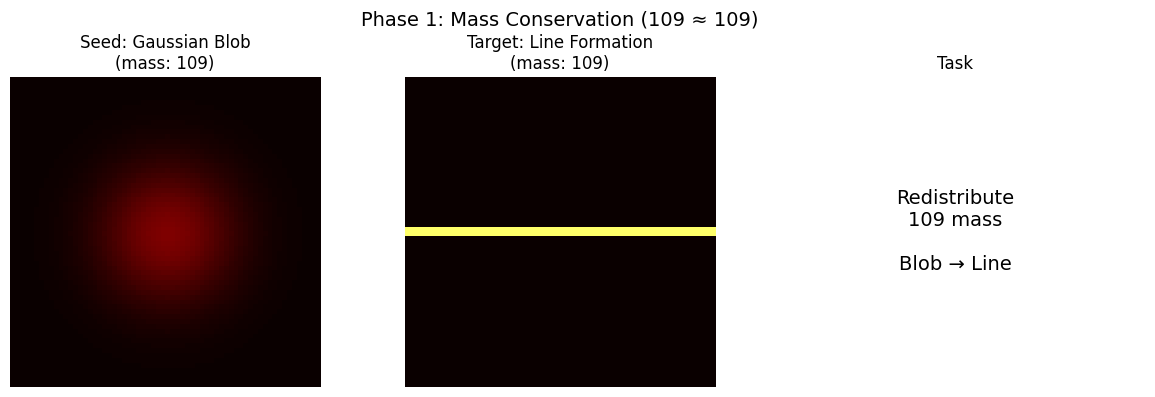


Seed mass: 109
Target mass: 109
Difference: 0.0 (0.0%)


In [238]:
# Visualize seed and target - they should have EQUAL mass
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(seed[..., 3], cmap='hot', vmin=0, vmax=1)
axes[0].set_title(f'Seed: Gaussian Blob\n(mass: {SEED_MASS:.0f})')
axes[0].axis('off')

axes[1].imshow(target[..., 3], cmap='hot', vmin=0, vmax=1)
axes[1].set_title(f'Target: Line Formation\n(mass: {TARGET_MASS:.0f})')
axes[1].axis('off')

# Show the redistribution task
axes[2].text(0.5, 0.5, f"Redistribute\n{SEED_MASS:.0f} mass\n\nBlob → Line", 
             ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
axes[2].set_title('Task')
axes[2].axis('off')

plt.suptitle(f'Phase 1: Mass Conservation ({SEED_MASS:.0f} ≈ {TARGET_MASS:.0f})', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nSeed mass: {SEED_MASS:.0f}")
print(f"Target mass: {TARGET_MASS:.0f}")
print(f"Difference: {abs(SEED_MASS - TARGET_MASS):.1f} ({abs(SEED_MASS - TARGET_MASS)/TARGET_MASS*100:.1f}%)")

## Training Setup

**Key principle**: Mass CONSERVATION. The NCA redistributes mass, it doesn't create or destroy it.

In [239]:
optimizer = create_optimizer(
    learning_rate=config.learning_rate,
    gradient_clip=config.gradient_clip
)

state = train_state.TrainState.create(
    apply_fn=child_nca.apply,
    params=params,
    tx=optimizer
)

pool = NCAPool(seed, config.pool_size)

print(f"Pool size: {config.pool_size}")
print(f"Batch size: {config.batch_size}")

Pool size: 1024
Batch size: 16


In [ ]:
# Training step with GRADIENT ACCUMULATION for stable loss landscape
# Accumulate gradients over multiple micro-batches before applying update
# Now with ORIENTATION information via target gradients

NUM_CHECKPOINTS = 4
FIXED_NUM_STEPS = 256

# === GRADIENT ACCUMULATION CONFIG ===
ACCUM_STEPS = 4  # Accumulate gradients over 4 micro-batches
# Effective batch size = config.batch_size * ACCUM_STEPS = 16 * 4 = 64

# Number of channels in formation signal (expanded for orientation)
SIGNAL_CHANNELS = 4  # [target_alpha, grad_x, grad_y, reserved]

# Mass conservation annealing schedule
MASS_WEIGHT_START = 0.01   # Lower weight to allow more shape learning early
MASS_WEIGHT_END = 0.15     # Final mass conservation weight
MASS_ANNEAL_START = 400    # Start annealing
MASS_ANNEAL_END = 800      # End annealing

def get_mass_weight(epoch):
    """Cosine annealing for mass conservation weight."""
    if epoch >= MASS_ANNEAL_END:
        return MASS_WEIGHT_END
    if epoch < MASS_ANNEAL_START:
        return MASS_WEIGHT_START
    
    progress = (epoch - MASS_ANNEAL_START) / (MASS_ANNEAL_END - MASS_ANNEAL_START)
    cosine_factor = (1 - np.cos(np.pi * progress)) / 2
    return MASS_WEIGHT_START + cosine_factor * (MASS_WEIGHT_END - MASS_WEIGHT_START)


def compute_target_gradients(target_alpha):
    """Compute Sobel gradients of target alpha for orientation information.
    
    Returns:
        grad_x: Horizontal gradient (positive = target extends right)
        grad_y: Vertical gradient (positive = target extends down)
    """
    sobel_x = jnp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=jnp.float32)
    sobel_y = sobel_x.T
    
    # Pad with wrap for toroidal topology
    target_padded = jnp.pad(target_alpha, ((1, 1), (1, 1)), mode='wrap')
    
    # Compute gradients via convolution
    target_4d = target_padded[None, :, :, None]
    
    grad_x = jax.lax.conv_general_dilated(
        target_4d, 
        sobel_x[:, :, None, None],
        (1, 1), 
        'VALID', 
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')
    )[0, :, :, 0]
    
    grad_y = jax.lax.conv_general_dilated(
        target_4d, 
        sobel_y[:, :, None, None],
        (1, 1), 
        'VALID', 
        dimension_numbers=('NHWC', 'HWIO', 'NHWC')
    )[0, :, :, 0]
    
    return grad_x, grad_y


def create_formation_signal_spatial(batch_size, height, width, target_alpha):
    """Create goal-conditioning signal with target alpha AND gradients.
    
    Each cell receives:
    - Channel 0: Target alpha at its position (density goal)
    - Channel 1: Target gradient X (horizontal direction to grow)
    - Channel 2: Target gradient Y (vertical direction to grow)
    - Channel 3: Reserved (set to 0)
    
    The gradients tell each cell which direction the target formation
    extends, enabling orientation-aware transitions.
    """
    # Compute target gradients for orientation
    grad_x, grad_y = compute_target_gradients(target_alpha)
    
    # Normalize gradients to [-1, 1] range for stable learning
    grad_magnitude = jnp.sqrt(grad_x**2 + grad_y**2 + 1e-8)
    max_mag = jnp.max(grad_magnitude)
    grad_x_norm = grad_x / (max_mag + 1e-8)
    grad_y_norm = grad_y / (max_mag + 1e-8)
    
    signal = jnp.zeros((batch_size, height, width, SIGNAL_CHANNELS))
    signal = signal.at[..., 0].set(target_alpha)    # Target density
    signal = signal.at[..., 1].set(grad_x_norm)     # Normalized gradient X
    signal = signal.at[..., 2].set(grad_y_norm)     # Normalized gradient Y
    signal = signal.at[..., 3].set(0.0)             # Reserved
    return signal


# Pre-compute formation signal with TARGET ALPHA + GRADIENTS as spatial guidance
FORMATION_SIGNAL = create_formation_signal_spatial(config.batch_size, GRID_SIZE, GRID_SIZE, target[..., 3])


@jax.jit
def compute_grads(params, batch, target, key, formation_signal, mass_weight):
    """Compute gradients for a single micro-batch WITHOUT applying them.
    
    This is the core of gradient accumulation - we compute gradients separately
    from applying them, allowing accumulation over multiple batches.
    """
    num_steps = FIXED_NUM_STEPS
    
    def loss_fn(params):
        keys = jax.random.split(key, num_steps)
        initial_mass = jnp.sum(batch[..., 3], axis=(1, 2))
        checkpoint_interval = num_steps // NUM_CHECKPOINTS
        
        def step(carry, inputs):
            step_idx, subkey = inputs
            # Write first 2 channels to state (backward compatible)
            state_in = carry.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
                formation_signal[..., :2]
            )
            # Pass FULL signal (4 channels) as parent_signal for the update rule
            new_state = child_nca.apply(
                {'params': params}, state_in, subkey, parent_signal=formation_signal
            )
            return new_state, new_state
        
        step_inputs = (jnp.arange(num_steps), keys)
        final, all_states = jax.lax.scan(step, batch, step_inputs)
        
        checkpoint_indices = jnp.array([
            checkpoint_interval - 1,
            2 * checkpoint_interval - 1,
            3 * checkpoint_interval - 1,
            4 * checkpoint_interval - 1
        ])
        checkpoint_indices = jnp.minimum(checkpoint_indices, num_steps - 1)
        checkpoint_states = all_states[checkpoint_indices]
        
        # Alpha-only formation loss
        checkpoint_errors = (checkpoint_states[..., 3:4] - target[..., 3:4]) ** 2
        checkpoint_mses = jnp.mean(checkpoint_errors, axis=(1, 2, 3, 4))
        checkpoint_weights = jnp.array([0.1, 0.2, 0.3, 0.4])
        formation_loss = jnp.sum(checkpoint_weights * checkpoint_mses)
        
        # Mass conservation loss
        checkpoint_masses = jnp.sum(checkpoint_states[..., 3], axis=(2, 3))
        relative_errors = jnp.abs(checkpoint_masses - initial_mass[None, :]) / (initial_mass[None, :] + 1e-6)
        mass_conservation_loss = jnp.mean(relative_errors)
        
        total_loss = formation_loss + mass_weight * mass_conservation_loss
        return total_loss, (final, formation_loss, mass_conservation_loss)
    
    (loss, (outputs, form_loss, mass_loss)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    return grads, loss, outputs, form_loss, mass_loss


@jax.jit
def apply_accumulated_grads(state, accumulated_grads, accum_steps):
    """Apply accumulated gradients after averaging."""
    avg_grads = jax.tree_util.tree_map(lambda g: g / accum_steps, accumulated_grads)
    avg_grads = normalize_gradients(avg_grads)
    state = state.apply_gradients(grads=avg_grads)
    return state


def accumulate_grads(grads1, grads2):
    """Add two gradient pytrees together."""
    return jax.tree_util.tree_map(lambda g1, g2: g1 + g2, grads1, grads2)


def zero_grads_like(params):
    """Create a zero gradient pytree with same structure as params."""
    return jax.tree_util.tree_map(jnp.zeros_like, params)


# Visualize the formation signal with gradients
print("Visualizing target gradients for orientation signal...")
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

test_signal = FORMATION_SIGNAL[0]

axes[0].imshow(test_signal[..., 0], cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Target Alpha\n(where to be)')
axes[0].axis('off')

axes[1].imshow(test_signal[..., 1], cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Gradient X\n(horizontal direction)')
axes[1].axis('off')

axes[2].imshow(test_signal[..., 2], cmap='RdBu', vmin=-1, vmax=1)
axes[2].set_title('Gradient Y\n(vertical direction)')
axes[2].axis('off')

# Direction visualization
grad_x = np.array(test_signal[..., 1])
grad_y = np.array(test_signal[..., 2])
angle = np.arctan2(grad_y, grad_x)
magnitude = np.sqrt(grad_x**2 + grad_y**2)
hsv = np.zeros((GRID_SIZE, GRID_SIZE, 3))
hsv[..., 0] = (angle + np.pi) / (2 * np.pi)
hsv[..., 1] = np.clip(magnitude * 2, 0, 1)
hsv[..., 2] = np.clip(magnitude * 2, 0, 1)
from matplotlib.colors import hsv_to_rgb
rgb = hsv_to_rgb(hsv)
axes[3].imshow(rgb)
axes[3].set_title('Direction (HSV)\n(color=angle)')
axes[3].axis('off')

plt.suptitle('Formation Signal: Alpha + Gradient Direction (ORIENTATION)', fontsize=14)
plt.tight_layout()
plt.show()

# Visualize the annealing schedule
epochs_preview = np.arange(0, PHASE1_EPOCHS)
weights_preview = [get_mass_weight(e) for e in epochs_preview]

plt.figure(figsize=(10, 4))
plt.plot(epochs_preview, weights_preview, 'b-', linewidth=2)
plt.axhline(y=MASS_WEIGHT_START, color='gray', linestyle='--', alpha=0.5, label=f'Start: {MASS_WEIGHT_START}')
plt.axhline(y=MASS_WEIGHT_END, color='gray', linestyle='--', alpha=0.5, label=f'End: {MASS_WEIGHT_END}')
plt.axvline(x=MASS_ANNEAL_START, color='green', linestyle=':', alpha=0.5, label=f'Anneal start: {MASS_ANNEAL_START}')
plt.axvline(x=MASS_ANNEAL_END, color='red', linestyle=':', alpha=0.5, label=f'Anneal end: {MASS_ANNEAL_END}')
plt.xlabel('Epoch')
plt.ylabel('Mass Conservation Weight')
plt.title('Cosine Annealing Schedule for Mass Conservation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nTraining step ready with GRADIENT ACCUMULATION + ORIENTATION.")
print(f"  - Micro-batch size: {config.batch_size}")
print(f"  - Accumulation steps: {ACCUM_STEPS}")
print(f"  - Effective batch size: {config.batch_size * ACCUM_STEPS}")
print(f"  - Fixed NCA steps: {FIXED_NUM_STEPS}")
print(f"  - Signal channels: {SIGNAL_CHANNELS} (alpha, grad_x, grad_y, reserved)")
print(f"  - Mass weight: {MASS_WEIGHT_START} -> {MASS_WEIGHT_END} (cosine)")
print(f"  - Anneal epochs: {MASS_ANNEAL_START} -> {MASS_ANNEAL_END}")
print(f"  - Loss: ALPHA CHANNEL ONLY (focused gradient signal)")
print(f"  - Formation signal: Target alpha + gradients (ORIENTATION)")

## Phase 1 Training

In [241]:
print("="*60)
print("PHASE 1: Redistribute Blob into Line Formation")
print("="*60)
print(f"Task: Conserve {SEED_MASS:.0f} mass while reshaping blob -> line")
print(f"Steps per iteration: {FIXED_NUM_STEPS}")
print(f"Gradient accumulation: {ACCUM_STEPS} micro-batches (effective batch size = {config.batch_size * ACCUM_STEPS})")
print(f"Annealing: mass_weight {MASS_WEIGHT_START} -> {MASS_WEIGHT_END} (epochs {MASS_ANNEAL_START}-{MASS_ANNEAL_END})")
print()

PATIENCE = 1000
MIN_DELTA = 1e-6

losses = []
form_losses = []
mass_losses = []
mass_weights_used = []
times = []
best_loss = float('inf')
best_params = None
epochs_without_improvement = 0

print("Compiling JIT (first epoch will be slow)...")

for epoch in range(PHASE1_EPOCHS):
    start_time = time.time()
    key, epoch_key = jax.random.split(key)
    
    # Get annealed mass conservation weight
    current_mass_weight = get_mass_weight(epoch)
    
    # === GRADIENT ACCUMULATION ===
    # Accumulate gradients over multiple micro-batches for stable loss landscape
    accumulated_grads = zero_grads_like(state.params)
    total_loss = 0.0
    total_form_loss = 0.0
    total_mass_loss = 0.0
    all_outputs = []
    all_indices = []
    
    for accum_idx in range(ACCUM_STEPS):
        # Sample a new micro-batch for each accumulation step
        epoch_key, sample_key, step_key = jax.random.split(epoch_key, 3)
        indices, batch = pool.sample(config.batch_size, sample_key)
        
        if epoch > config.damage_start_epoch:
            epoch_key, damage_key = jax.random.split(epoch_key)
            batch = pool.apply_damage(batch, config.damage_samples, damage_key)
        
        # Compute gradients for this micro-batch (without applying)
        grads, loss, outputs, form_loss, mass_loss = compute_grads(
            state.params, batch, target, step_key, FORMATION_SIGNAL, current_mass_weight
        )
        
        # Accumulate gradients
        accumulated_grads = accumulate_grads(accumulated_grads, grads)
        
        # Track losses (average over accum steps)
        total_loss += float(loss)
        total_form_loss += float(form_loss)
        total_mass_loss += float(mass_loss)
        
        # Track outputs for pool update
        all_outputs.append(outputs)
        all_indices.append(indices)
    
    # Average the metrics
    avg_loss = total_loss / ACCUM_STEPS
    avg_form_loss = total_form_loss / ACCUM_STEPS
    avg_mass_loss = total_mass_loss / ACCUM_STEPS
    
    # Apply accumulated (and averaged) gradients
    state = apply_accumulated_grads(state, accumulated_grads, ACCUM_STEPS)
    
    # Check for NaN/Inf
    if np.isnan(avg_loss) or np.isinf(avg_loss):
        print(f"\nEarly stopping at epoch {epoch}: loss is {avg_loss}")
        if best_params is not None:
            state = state.replace(params=best_params)
        break
    
    # Track best model
    if avg_loss < best_loss - MIN_DELTA:
        best_loss = avg_loss
        best_params = state.params
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}: no improvement for {PATIENCE} epochs")
        state = state.replace(params=best_params)
        break
    
    # Pool update: use outputs from ALL micro-batches
    for outputs, indices in zip(all_outputs, all_indices):
        per_sample_losses = jnp.mean((outputs[..., 3:4] - target[..., 3:4]) ** 2, axis=(1, 2, 3))
        pool.update(indices, outputs, per_sample_losses)
    
    elapsed = time.time() - start_time
    losses.append(avg_loss)
    form_losses.append(avg_form_loss)
    mass_losses.append(avg_mass_loss)
    mass_weights_used.append(current_mass_weight)
    times.append(elapsed)
    
    if epoch % config.log_interval == 0:
        # Use last micro-batch outputs for logging
        current_mass = float(jnp.mean(jnp.sum(all_outputs[-1][..., 3], axis=(1, 2))))
        mass_retention = current_mass / SEED_MASS
        print(f"Epoch {epoch:4d}: loss={avg_loss:.6f} (form:{avg_form_loss:.6f}, conserv:{avg_mass_loss:.4f}), " +
              f"mass={current_mass:.0f}/{SEED_MASS:.0f} ({mass_retention:.0%}), mw={current_mass_weight:.2f}, {elapsed:.2f}s")

print(f"\nPhase 1 complete. Best loss: {best_loss:.6f}")
if len(times) > 1:
    print(f"Average time per epoch (after JIT): {np.mean(times[1:]):.3f}s")

PHASE 1: Redistribute Blob into Line Formation
Task: Conserve 109 mass while reshaping blob -> line
Steps per iteration: 256
Gradient accumulation: 32 micro-batches (effective batch size = 512)
Annealing: mass_weight 0.01 -> 0.3 (epochs 0-10)

Compiling JIT (first epoch will be slow)...
Epoch    0: loss=0.026586 (form:0.021612, conserv:0.4974), mass=55/109 (50%), mw=0.01, 26.31s
Epoch   10: loss=0.148259 (form:0.019667, conserv:0.4286), mass=88/109 (81%), mw=0.30, 22.04s
Epoch   20: loss=0.082433 (form:0.017926, conserv:0.2150), mass=94/109 (86%), mw=0.30, 17.92s
Epoch   30: loss=0.056211 (form:0.018633, conserv:0.1253), mass=59/109 (55%), mw=0.30, 17.93s
Epoch   40: loss=0.066301 (form:0.017599, conserv:0.1623), mass=49/109 (45%), mw=0.30, 17.92s
Epoch   50: loss=0.098972 (form:0.019458, conserv:0.2650), mass=59/109 (54%), mw=0.30, 17.93s
Epoch   60: loss=0.038783 (form:0.019889, conserv:0.0630), mass=54/109 (50%), mw=0.30, 17.93s
Epoch   70: loss=0.041229 (form:0.021882, conserv:0.06

## Training Curves

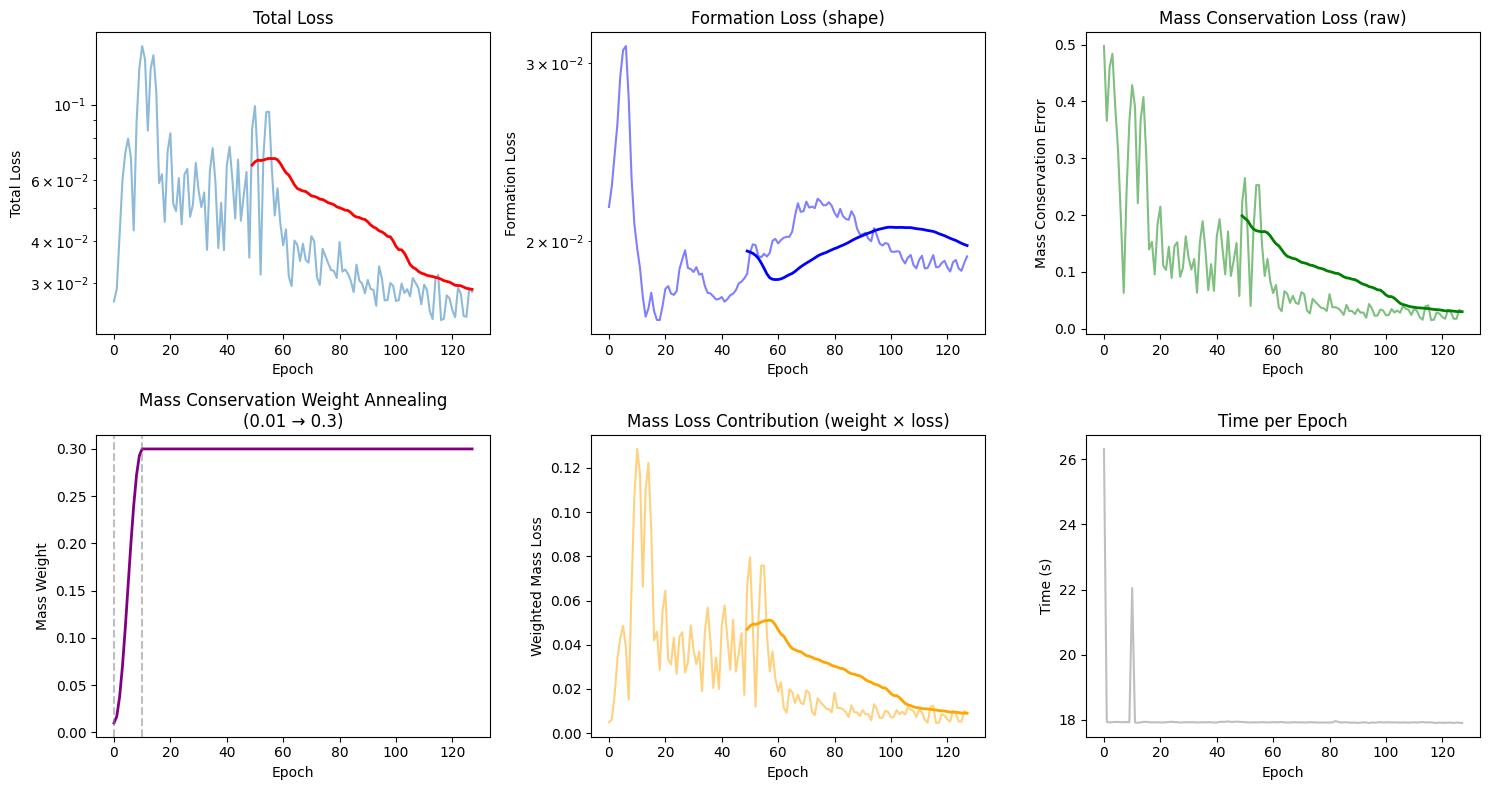

In [242]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

window = 50

# Total loss
axes[0, 0].plot(losses, alpha=0.5)
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Total Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_yscale('log')

# Formation loss
axes[0, 1].plot(form_losses, alpha=0.5, color='blue')
if len(form_losses) > window:
    smoothed = np.convolve(form_losses, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(range(window-1, len(form_losses)), smoothed, 'b-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Formation Loss')
axes[0, 1].set_title('Formation Loss (shape)')
axes[0, 1].set_yscale('log')

# Mass conservation loss (raw, before weighting)
axes[0, 2].plot(mass_losses, alpha=0.5, color='green')
if len(mass_losses) > window:
    smoothed = np.convolve(mass_losses, np.ones(window)/window, mode='valid')
    axes[0, 2].plot(range(window-1, len(mass_losses)), smoothed, 'g-', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Mass Conservation Error')
axes[0, 2].set_title('Mass Conservation Loss (raw)')

# Mass weight annealing schedule
axes[1, 0].plot(mass_weights_used, 'purple', linewidth=2)
axes[1, 0].axvline(x=MASS_ANNEAL_START, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axvline(x=MASS_ANNEAL_END, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Mass Weight')
axes[1, 0].set_title(f'Mass Conservation Weight Annealing\n({MASS_WEIGHT_START} → {MASS_WEIGHT_END})')

# Weighted mass loss contribution
weighted_mass = [w * m for w, m in zip(mass_weights_used, mass_losses)]
axes[1, 1].plot(weighted_mass, alpha=0.5, color='orange')
if len(weighted_mass) > window:
    smoothed = np.convolve(weighted_mass, np.ones(window)/window, mode='valid')
    axes[1, 1].plot(range(window-1, len(weighted_mass)), smoothed, 'orange', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Weighted Mass Loss')
axes[1, 1].set_title('Mass Loss Contribution (weight × loss)')

# Time per epoch
axes[1, 2].plot(times, alpha=0.5, color='gray')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Time (s)')
axes[1, 2].set_title('Time per Epoch')

plt.tight_layout()
plt.show()

## Save Checkpoint

In [243]:
checkpoint = {
    'params': state.params,
    'config': {
        'grid_size': GRID_SIZE,
        'num_channels': NUM_CHANNELS,
        'hidden_dim': 256,
        'goal_conditioned': True,
        'phase': 1,
        'target_mass': TARGET_MASS,
    },
    'metrics': {
        'losses': losses,
        'form_losses': form_losses,
        'mass_losses': mass_losses,
        'best_loss': best_loss,
    }
}

with open(CHECKPOINT_PATH, 'wb') as f:
    pickle.dump(checkpoint, f)

print(f"Checkpoint saved to {CHECKPOINT_PATH}")
print(f"Best loss: {best_loss:.6f}")

Checkpoint saved to checkpoints/phase1_line.pkl
Best loss: 0.023445


---

# Evaluation & Visualization

In [ ]:
def run_model(initial_state, params, key, num_steps=150):
    """Run the NCA and return trajectory.
    
    Uses the 4-channel formation signal with alpha + gradients (orientation).
    """
    # Create 4-channel signal with alpha + gradients (same as training)
    signal = create_formation_signal_spatial(1, GRID_SIZE, GRID_SIZE, target[..., 3])
    signal_single = signal[0]
    
    trajectory = [initial_state]
    state_curr = initial_state
    
    for i in range(num_steps):
        key, subkey = jax.random.split(key)
        # Write first 2 channels to state (backward compatible)
        state_curr = state_curr.at[..., CHILD_CHANNELS.PARENT_SIGNAL_START:CHILD_CHANNELS.PARENT_SIGNAL_END].set(
            signal_single[..., :2]
        )
        # Pass full 4-channel signal as parent_signal
        state_curr = child_nca.apply(
            {'params': params}, state_curr, subkey, parent_signal=signal_single
        )
        trajectory.append(state_curr)
    
    return trajectory

key, eval_key = jax.random.split(key)
trajectory = run_model(seed, state.params, eval_key, num_steps=150)
print(f"Generated trajectory with {len(trajectory)} frames")
print(f"Using {SIGNAL_CHANNELS}-channel signal (alpha + gradients for orientation)")

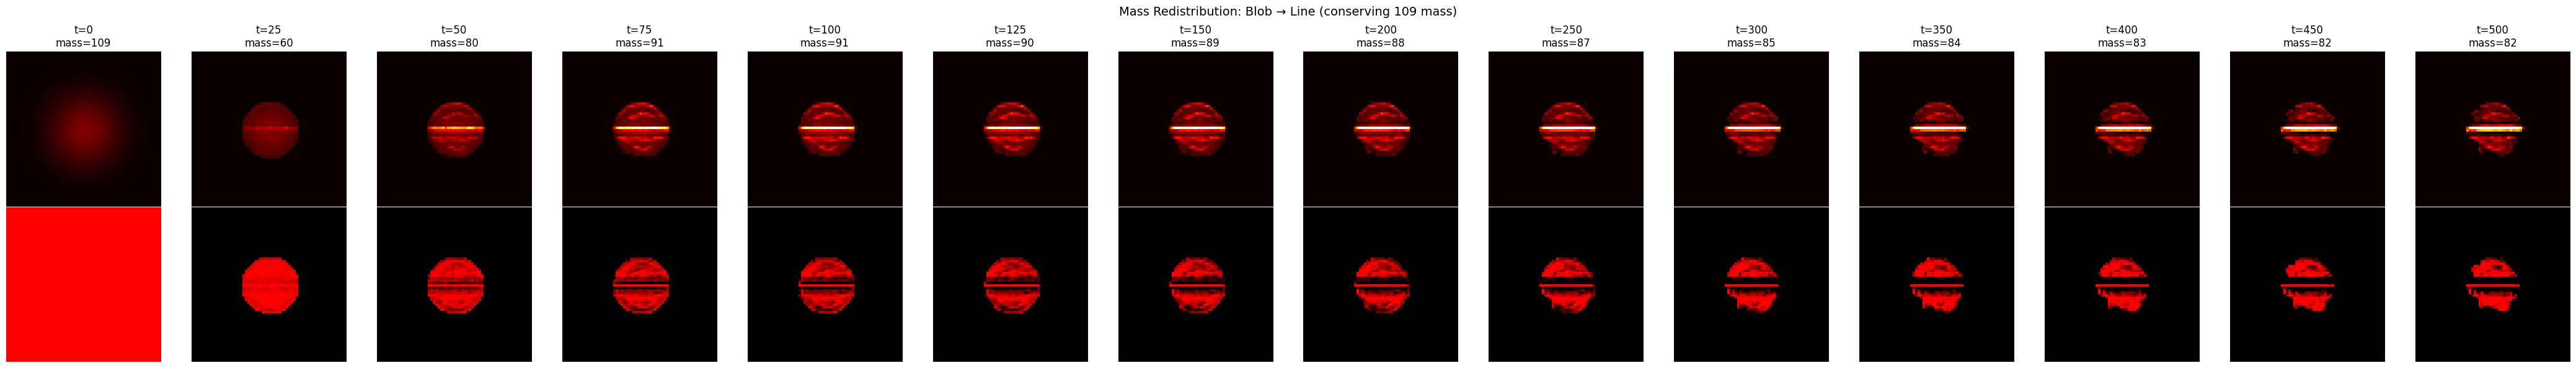

In [245]:
# Visualize evolution - mass should stay constant while shape changes
timesteps = [0, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500]
fig, axes = plt.subplots(2, len(timesteps), figsize=(3*len(timesteps), 6))

for i, t in enumerate(timesteps):
    if t < len(trajectory):
        frame = trajectory[t]
        mass = float(jnp.sum(frame[..., 3]))
        
        axes[0, i].imshow(frame[..., 3], cmap='hot', vmin=0, vmax=1)
        axes[0, i].set_title(f't={t}\nmass={mass:.0f}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(np.clip(frame[..., :3], 0, 1))
        axes[1, i].axis('off')

axes[0, 0].set_ylabel('Alpha (density)', fontsize=12)
axes[1, 0].set_ylabel('RGB', fontsize=12)

plt.suptitle(f'Mass Redistribution: Blob → Line (conserving {SEED_MASS:.0f} mass)', fontsize=14)
plt.tight_layout()
plt.show()

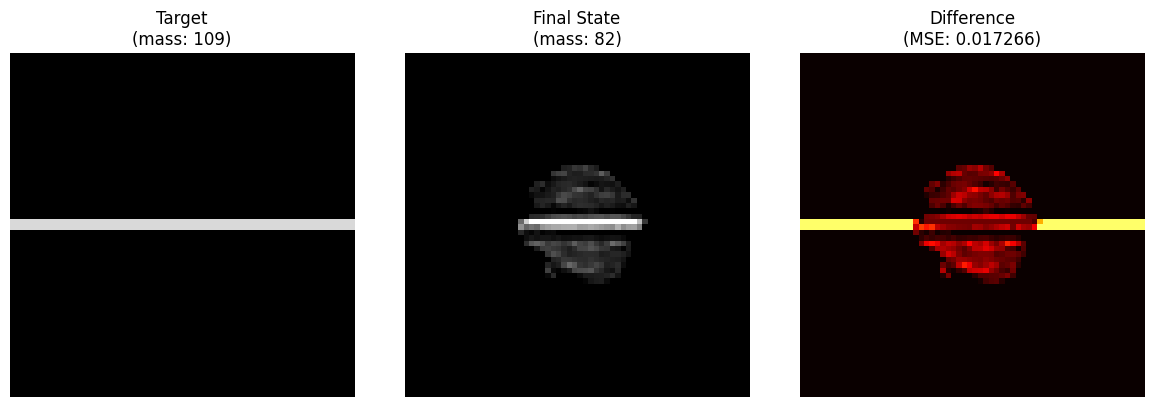

In [246]:
# Compare final state to target
final_state = trajectory[-1]
final_mass = float(jnp.sum(final_state[..., 3]))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(target[..., 3], cmap='gray', vmin=0, vmax=1)
axes[0].set_title(f'Target\n(mass: {TARGET_MASS:.0f})')
axes[0].axis('off')

axes[1].imshow(final_state[..., 3], cmap='gray', vmin=0, vmax=1)
axes[1].set_title(f'Final State\n(mass: {final_mass:.0f})')
axes[1].axis('off')

diff = np.abs(np.array(target[..., 3]) - np.array(final_state[..., 3]))
mse = np.mean(diff**2)
axes[2].imshow(diff, cmap='hot', vmin=0, vmax=1)
axes[2].set_title(f'Difference\n(MSE: {mse:.6f})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

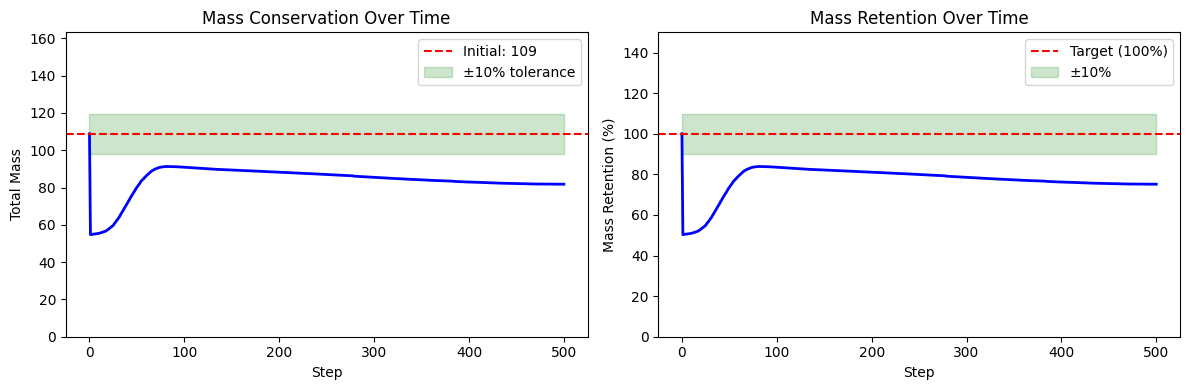

Initial mass: 109
Final mass: 82
Mass retention: 75.2%


In [247]:
# Mass conservation analysis - mass should stay FLAT
masses = [float(jnp.sum(t[..., 3])) for t in trajectory]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Mass over time
axes[0].plot(masses, 'b-', linewidth=2)
axes[0].axhline(y=SEED_MASS, color='r', linestyle='--', label=f'Initial: {SEED_MASS:.0f}')
axes[0].fill_between(range(len(masses)), SEED_MASS*0.9, SEED_MASS*1.1, 
                     alpha=0.2, color='green', label='±10% tolerance')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Total Mass')
axes[0].set_title('Mass Conservation Over Time')
axes[0].legend()
axes[0].set_ylim(0, SEED_MASS * 1.5)

# Mass retention %
retention = [m / SEED_MASS * 100 for m in masses]
axes[1].plot(retention, 'b-', linewidth=2)
axes[1].axhline(y=100, color='r', linestyle='--', label='Target (100%)')
axes[1].fill_between(range(len(retention)), 90, 110, alpha=0.2, color='green', label='±10%')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Mass Retention (%)')
axes[1].set_title('Mass Retention Over Time')
axes[1].legend()
axes[1].set_ylim(0, 150)

plt.tight_layout()
plt.show()

print(f"Initial mass: {SEED_MASS:.0f}")
print(f"Final mass: {masses[-1]:.0f}")
print(f"Mass retention: {masses[-1]/SEED_MASS:.1%}")

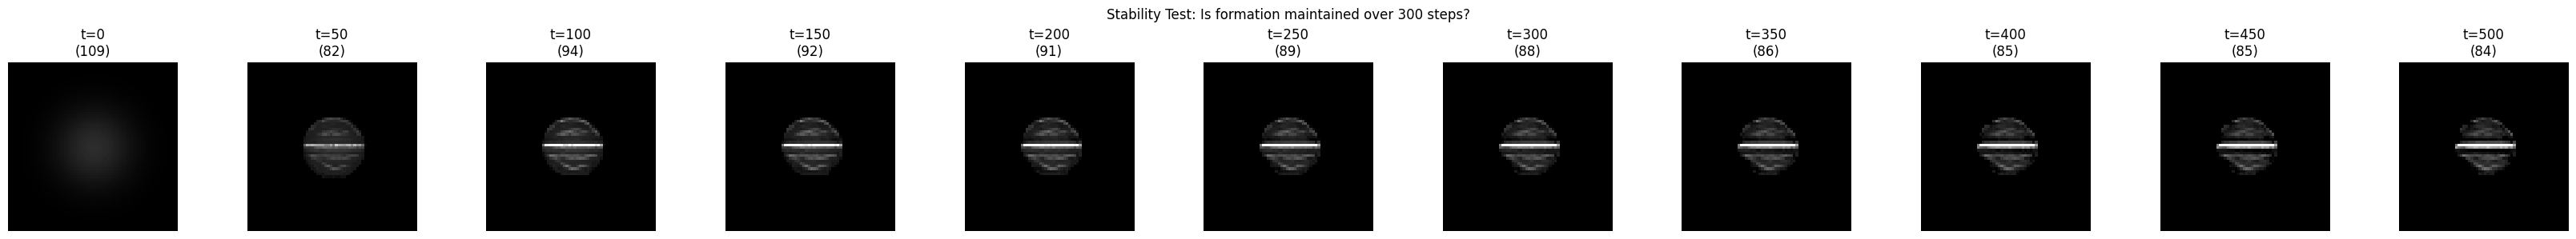

In [248]:
# Stability test
key, stability_key = jax.random.split(key)
long_trajectory = run_model(seed, state.params, stability_key, num_steps=500)

check_points = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
fig, axes = plt.subplots(1, len(check_points), figsize=(3*len(check_points), 3))

for i, t in enumerate(check_points):
    if t < len(long_trajectory):
        mass = float(jnp.sum(long_trajectory[t][..., 3]))
        axes[i].imshow(long_trajectory[t][..., 3], cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f't={t}\n({mass:.0f})')
        axes[i].axis('off')

plt.suptitle('Stability Test: Is formation maintained over 300 steps?', fontsize=12)
plt.tight_layout()
plt.show()

## Success Criteria Check

In [249]:
final_state = trajectory[-1]
final_mass = float(jnp.sum(final_state[..., 3]))
# Use ALPHA CHANNEL ONLY for formation loss (matching training loss)
final_form_loss = np.mean((np.array(final_state[..., 3]) - np.array(target[..., 3])) ** 2)
mass_retention = final_mass / SEED_MASS

# Check stability at t=300
late_mass = float(jnp.sum(long_trajectory[-1][..., 3]))
stability = late_mass / SEED_MASS  # Compare to initial, not final

print("=" * 60)
print("PHASE 1 SUCCESS CRITERIA")
print("=" * 60)

criteria = [
    ("Formation MSE < 0.01 (alpha only)", final_form_loss, 0.01, final_form_loss < 0.01),
    ("Mass conserved (90-110%)", mass_retention, "0.9-1.1", 0.9 <= mass_retention <= 1.1),
    ("Stable at t=300 (90-110%)", stability, "0.9-1.1", 0.9 <= stability <= 1.1),
]

all_passed = True
for name, value, threshold, passed in criteria:
    status = "PASS" if passed else "FAIL"
    if isinstance(value, float):
        print(f"{name}: {value:.4f} (threshold: {threshold}) [{status}]")
    else:
        print(f"{name}: {value} (threshold: {threshold}) [{status}]")
    if not passed:
        all_passed = False

print("=" * 60)
print(f"\nSummary:")
print(f"  Initial mass (seed): {SEED_MASS:.0f}")
print(f"  Target mass: {TARGET_MASS:.0f}")
print(f"  Final mass: {final_mass:.0f} ({mass_retention:.0%} of initial)")
print(f"  Formation MSE (alpha only): {final_form_loss:.6f}")

print("\n" + "=" * 60)
if all_passed:
    print("ALL CRITERIA PASSED - Ready for Phase 2!")
    print("\nNext: Run phase2_formation_transitions.ipynb")
else:
    print("SOME CRITERIA FAILED - Consider more training")
    print("\nTry: Set RESET=False and run training again")

PHASE 1 SUCCESS CRITERIA
Formation MSE < 0.01 (alpha only): 0.01726604625582695 (threshold: 0.01) [FAIL]
Mass conserved (90-110%): 0.7515 (threshold: 0.9-1.1) [FAIL]
Stable at t=300 (90-110%): 0.7738 (threshold: 0.9-1.1) [FAIL]

Summary:
  Initial mass (seed): 109
  Target mass: 109
  Final mass: 82 (75% of initial)
  Formation MSE (alpha only): 0.017266

SOME CRITERIA FAILED - Consider more training

Try: Set RESET=False and run training again
